In [8]:
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob
from IPython.display import FileLink
from typing import Union, Tuple, Optional

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler
from torch_em.util.util import get_random_colors

import micro_sam.training as sam_training
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

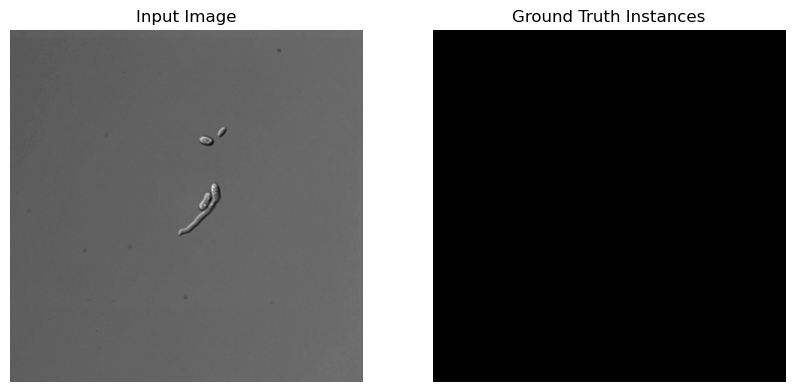

In [18]:
# set your folders
image_dir = "/Users/sambra/Documents/GitHub/sam_based_fungal_app/cellpose_training/training_images/MeOH_plate_A2-1391_mask.tif"
segmentation_dir = "/Users/sambra/Documents/GitHub/sam_based_fungal_app/cellpose_training/training_labels_tif"

image_path = "/Users/sambra/Documents/GitHub/sam_based_fungal_app/cellpose_training/training_images/MeOH_plate_A2-1391.tif"
segmentation_path_download = "/Users/sambra/Downloads/MeOH_plate_A2-1391_mask.tif"
segmentation_path_positive_control = "/Users/sambra/Documents/GitHub/sam_based_fungal_app/cellpose_training/training_labels_tif/MeOH_plate_A2-1391_mask.tif"

image = imageio.imread(image_path)
segmentation = imageio.imread(segmentation_path_download)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(image, cmap="gray")
ax[0].set_title("Input Image")
ax[0].axis("off")

segmentation = connected_components(segmentation)
ax[1].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
ax[1].set_title("Ground Truth Instances")
ax[1].axis("off")

plt.show()
plt.close()


In [3]:
raw_key, label_key = "*.tif", "*.tif"

In [4]:
train_roi = np.s_[:70, :, :]
val_roi = np.s_[70:, :, :]

In [5]:
batch_size = 1  # the training batch size
patch_shape = (1, 512, 512)  # the size of patches for training

In [6]:
train_instance_segmentation = True

In [7]:
sampler = MinInstanceSampler(min_size=25)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

train_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    rois=train_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    rois=val_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

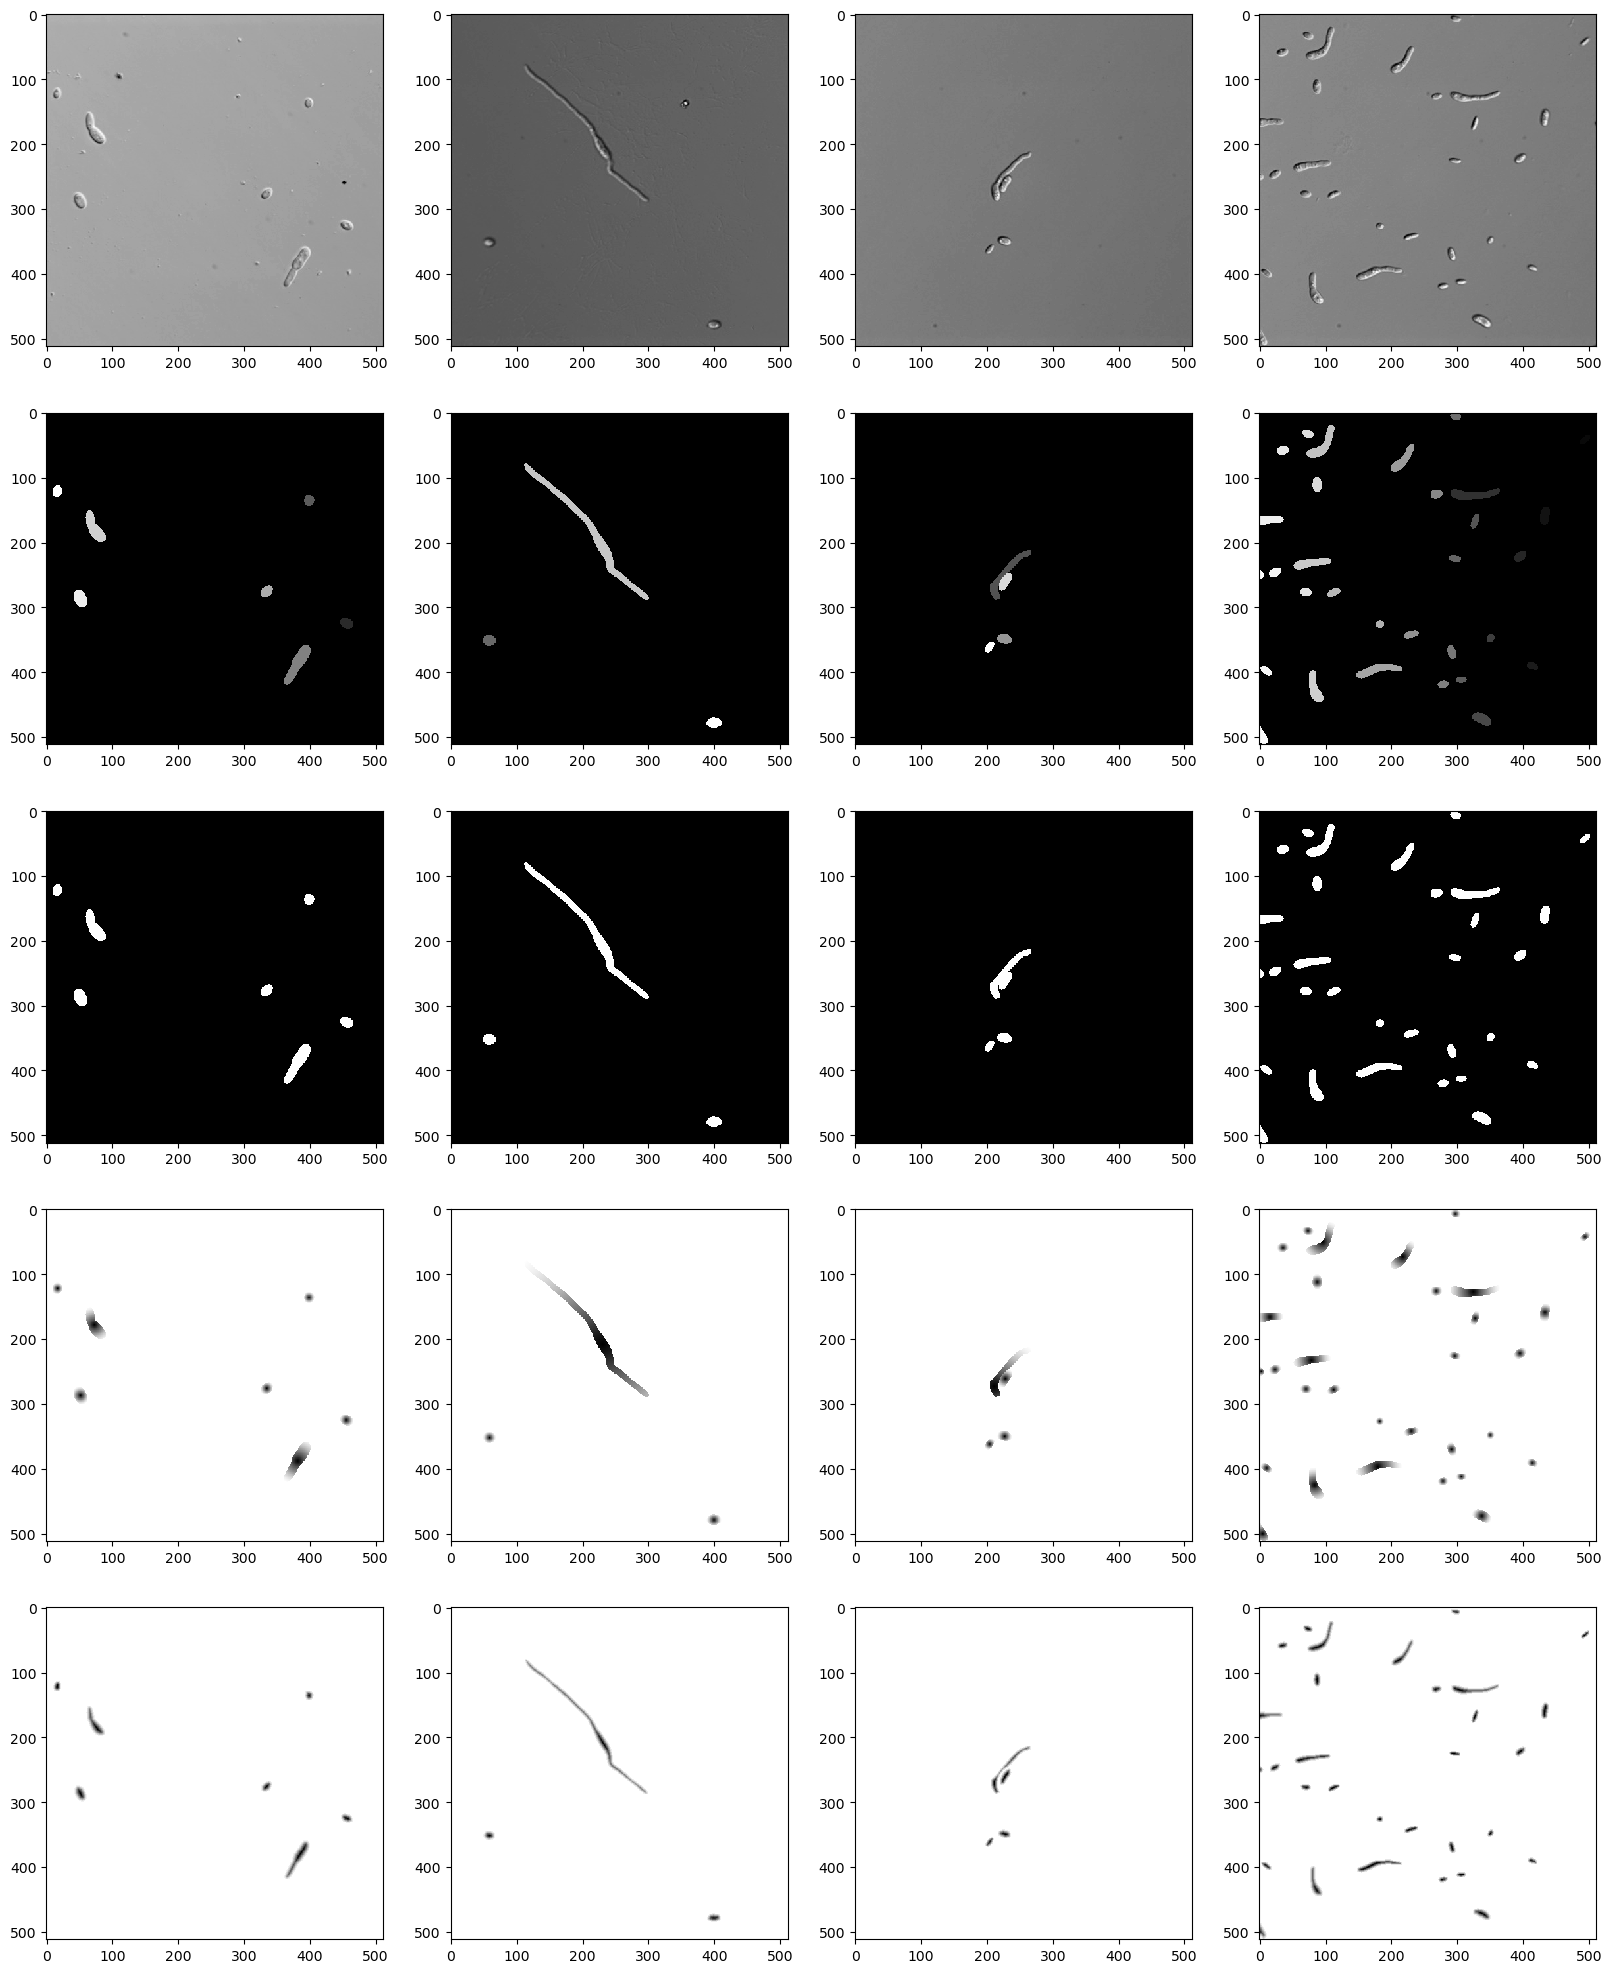

In [8]:
check_loader(train_loader, 4, plt=True)


In [ ]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Using device:", device)

# All hyperparameters for training.
n_objects_per_batch = 8  # the number of objects per batch that will be sampled
n_epochs = 3  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_t"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_test"

print(device)



Using device: mps
mps


In [ ]:
# Run training

root_dir = os.getcwd()

sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(root_dir, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
    freeze=["image_encoder", "prompt_encoder"],  # train mask decoder only
)

Verifying labels in 'val' dataloader: 100%|██████████| 50/50 [00:01<00:00, 33.51it/s]


Start fitting for 300 iterations /  3 epochs
with 100 iterations per epoch
Training with mixed precision


Epoch 0:   4%|▍         | 13/300 [11:36<7:14:12, 90.77s/it]

KeyboardInterrupt: 

In [ ]:
# Let's spot our best checkpoint and download it to get started with the annotation tool
best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")

# Download link is automatically generated for the best model.
print("Click here \u2193")
FileLink(best_checkpoint)

In [ ]:
def run_automatic_instance_segmentation(
    image: np.ndarray,
    checkpoint_path: Union[os.PathLike ,str],
    model_type: str = "vit_b_lm",
    device: Optional[Union[str, torch.device]] = None,
    tile_shape: Optional[Tuple[int, int]] = None,
    halo: Optional[Tuple[int, int]] = None,
):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.
        tile_shape: The tile shape for tiling-based segmentation.
        halo: The overlap shape on each side per tile for stitching the segmented tiles.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        is_tiled=(tile_shape is not None),  # whether to run automatic segmentation.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,  # the filepath to image or the input array for automatic segmentation.
        ndim=2,  # the number of input dimensions.
        tile_shape=tile_shape,  # the tile shape for tiling-based prediction.
        halo=halo,  # the overlap shape for tiling-based prediction.
    )

    return prediction

In [ ]:
zip_path = os.path.join(root_dir, "data", "DIC-C2DH-HeLa-test.zip")
!wget -q http://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip -O $zip_path

trg_dir = os.path.join(root_dir, "data", "test")
os.makedirs(trg_dir, exist_ok=True)
!unzip -q $zip_path -d trg_dir

In [ ]:
assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

# Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
image_paths = image_paths[:5]

for image_path in image_paths:
    image = imageio.imread(image_path)

    # Predicted instances.
    # NOTE: If you have large images, we recommend using tiling for automatic segmentation.
    # eg. for a training patch size of (512, 512), you can provide the following example combination:
    # 'tile_shape=(384, 384). halo=(64, 64)' for running automatic segmentation over tiles.
    prediction = run_automatic_instance_segmentation(
        image=image,
        checkpoint_path=best_checkpoint,
        model_type=model_type,
        device=device,
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(prediction, cmap=get_random_colors(prediction), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Predictions (AIS)")

    plt.show()
    plt.close()

In [ ]:
import os
import numpy as np
import tifffile as tiff

# Input: folder with raw images + npy masks
image_dir = "/Users/sambra/Desktop/training_images"
mask_dir = image_dir  # if masks are in the same folder, otherwise set separately
out_dir = "/Users/sambra/Desktop/training_labels_tif"
os.makedirs(out_dir, exist_ok=True)


def stack_to_instances(stack, tie_break="largest_first"):
    """
    Convert (N,H,W) binary masks into a single (H,W) instance label image.
    Background = 0, cells = 1..N.
    """
    stack = (stack > 0).astype(np.uint8)
    N, H, W = stack.shape

    if tie_break == "largest_first":
        # largest masks first → overwrite smaller overlaps
        areas = stack.reshape(N, -1).sum(axis=1)
        order = np.argsort(-areas)
    else:
        # default: in order of appearance
        order = np.arange(N)

    inst = np.zeros((H, W), dtype=np.uint32)
    for i, k in enumerate(order, start=1):
        m = stack[k].astype(bool)
        inst[m] = i
    return inst.astype(np.uint16)


# Find all .npy masks
mask_paths = sorted(glob(os.path.join(mask_dir, "*.npy")))

converted = 0
for mask_path in mask_paths:
    basename = os.path.splitext(os.path.basename(mask_path))[0]
    out_path = os.path.join(out_dir, f"{basename}.tif")

    # Load .npy file
    stack = np.load(mask_path, allow_pickle=True)
    if stack.ndim == 2:
        stack = stack[None, ...]  # single mask → (1,H,W)

    # Convert to instance label image
    inst = stack_to_instances(stack, tie_break="largest_first")

    # Save as compressed TIFF
    tiff.imwrite(out_path, inst, compression="zlib")
    converted += 1

print(f"✅ Converted {converted} masks to {out_dir}")

In [6]:
import os

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components
from torch_em.util.util import get_random_colors

IMAGE_PATH = "/Users/sambra/Desktop/PDB DvelB 6h R2-0286.TIF"
MASK_PATH  = "/Users/sambra/Desktop/PDB DvelB 6h R2-0286.tif"


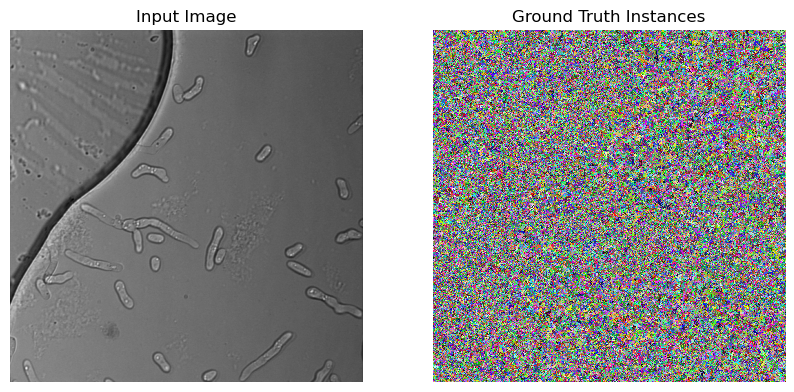

In [7]:
image = imageio.imread(IMAGE_PATH)
segmentation = imageio.imread(MASK_PATH)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(image, cmap="gray")
ax[0].set_title("Input Image")
ax[0].axis("off")

segmentation = connected_components(segmentation)
ax[1].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
ax[1].set_title("Ground Truth Instances")
ax[1].axis("off")

plt.show()
plt.close()

: 